In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='ticks')

from mini_repo.classes.dbclasses import dbMouse, dbExperiment
from mini_repo.classes.classes import pcExperimentGroup

import mini_repo.analysis.behavior_analysis as ba
import mini_repo.analysis.place_cell_analysis as pca

from scipy import stats
from scipy.ndimage.filters import gaussian_filter1d, gaussian_filter, maximum_filter
from scipy.stats import ttest_rel, mannwhitneyu
import numpy as np

import pandas as pd

import h5py
import cPickle as pkl

### Loading in experiments to be analyzed

In [ ]:
# Note: Cells in this subsection aren't strictly necessary as everything plotted here has been computed previously
# using the Robo_analysis.py script (and the calculate_spatial_info.py script)
# But this reflects the experiments used to generate those data

In [2]:
mice = ['hb169_2', 'hb177_2', 'hb184_3', 'hb189_1', 'hb190_1', 'hb192_1']
expts = []
for mouse in mice:
    expts.extend(dbMouse(mouse).imagingExperiments())

# Filter to only include random foraging experiments
expts = [e for e in expts if 'GOL' not in e.get('tSeriesDirectory')]
# remove one experiments with lots of data drop
bad_tseries = ['/data2/Heike/hb177_2/190627/hb177_2_RF_FOV2_day2-001']
expts = [e for e in expts if not np.any([x in e.get('tSeriesDirectory') for x in bad_tseries])]

# assert(len(expts) == 24)

In [5]:
green_kwargs = {'imaging_label': 'drawn_green',
                'nPositionBins': 100,
                'channel': 'Ch2',
                'demixed': False,
                'pf_subset': None,
                'signal': 'spikes'}

red_kwargs = {'imaging_label': 'drawn_red',
                'nPositionBins': 100,
                'channel': 'Ch2',
                'demixed': False,
                'pf_subset': None,
                'signal': 'spikes'}

wt_grp = pcExperimentGroup(expts, **green_kwargs)
ko_grp = pcExperimentGroup(expts, **red_kwargs)

In [137]:
expt_dict = {}
for expt in expts:
    mouse_name = expt.parent.mouse_name
    
    if mouse_name in expt_dict:
        expt_dict[mouse_name].append(expt.trial_id)
    else:
        expt_dict[mouse_name] = [expt.trial_id]

In [138]:
expt_dict

## Should look like this:
'''
{'hb169_2': [20295, 20296, 20293, 20297],
 'hb177_2': [20522, 20523, 20666, 20668, 20675],
 'hb184_3': [20812, 20811, 20891, 20892, 20894, 20893, 20900, 20899],
 'hb189_1': [21297, 21298, 21294, 21296, 21295, 21299, 21312, 21311],
 'hb190_1': [21305, 21302, 21303, 21300, 21301, 21304, 21314, 21313],
 'hb192_1': [21387, 21386, 21388, 21389, 21459, 21457, 21456, 21455]}
 '''

{'hb169_2': [20295, 20296, 20293, 20297],
 'hb177_2': [20522, 20523, 20666, 20668, 20675],
 'hb184_3': [20812, 20811, 20891, 20892, 20894, 20893, 20900, 20899],
 'hb189_1': [21297, 21298, 21294, 21296, 21295, 21299, 21312, 21311],
 'hb190_1': [21305, 21302, 21303, 21300, 21301, 21304, 21314, 21313],
 'hb192_1': [21387, 21386, 21388, 21389, 21459, 21457, 21456, 21455]}

### Spatial Info calculation

In [573]:
red_df = pd.DataFrame([])
green_df = pd.DataFrame([])

# Transforms and re-saves metrics calculated in calculate_spatial_info.py
dirname = './spatial_info'

for filename in os.listdir(dirname):
    
    if 'red' in filename:
        df = pd.read_pickle(os.path.join(dirname, filename))
        red_df = pd.concat([red_df, df])
    elif 'green' in filename:
        df = pd.read_pickle(os.path.join(dirname, filename))
        green_df = pd.concat([green_df, df])

In [921]:
def pvalue(x):
    
    pval = (100 - x['spatial_info_pct'])/100.
    
    return pval < 0.01

dfs = []
for df in [green_df, red_df]:
    df['value'] = df.apply(pvalue, axis=1)
    dfs.append(df)

with open('./data/robo_drawn/info.pkl', 'wb') as fp:
    pkl.dump(dfs, fp)

### Scatter plots comparing within-FOV metrics

In [696]:
def formatPlot(ax, offset=4):
    for axis in ['left', 'right', 'bottom', 'top']:
        ax.spines[axis].set_linewidth(2)
    ax.tick_params(labelsize=14, length=6, width=2)
    sns.despine(ax=ax, offset=offset)
    
def square(ax):
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    minval = np.min([xmin, ymin])
    maxval = np.max([xmax, ymax])
    
    ax.set_xlim([minval, maxval])
    ax.set_ylim([minval, maxval])

def point_plot(dfs, ax, title=None, ticks=None):
        
    grp_dfs = []
    for df in dfs:
        grp_dfs.append(df.groupby(['expt_id', 'mouse', 'FOV'], as_index=False).mean())
        
    grp_df = grp_dfs[0].merge(grp_dfs[1], on=['expt_id', 'mouse', 'FOV'], suffixes=['_wt', '_ko'])
    
    sns.scatterplot(x='value_ko', y='value_wt', data=grp_df, ax=ax, color='0.5', s=35, edgecolor='none')
    
    grp_df = grp_df.groupby(['mouse', 'FOV'], as_index=False).mean()
    grp_df['id'] = grp_df.apply(lambda x: x['mouse'] + '_' + str(x['FOV']), axis=1)
    
    sns.scatterplot(x='value_ko', y='value_wt', hue='id', data=grp_df, ax=ax, s=60, legend=False, edgecolor='k')
    
    p = ttest_rel(grp_df['value_ko'], grp_df['value_wt'])[1]
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = ''

    ax.annotate('p = {:.3f}{}'.format(p, stars), xy=(0.1, 0.8), xycoords='axes fraction', fontsize=14)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('KO', fontsize=14)
    ax.set_ylabel('WT', fontsize=14)
    formatPlot(ax)
        
        
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    square(ax)
    
    ax.set_aspect(1 / ax.get_data_ratio())
    
    minval, maxval = ax.get_xlim()
    ax.plot([minval, maxval], [minval, maxval], 'k--', zorder=0)
    

In [11]:
# Assumes all data has been pre-computed using associated scripts
# and stored to a 'data' folder

data_path = './data/{}.pkl'

fnames = ['run_freq', 'silent', 'sensitivity', 'specificity', 'percentage', 'width', 'autocorr', 'info']
labels = ['Event Frequency (Hz)', 'Fraction Silent Cells', 'Sensitivity',
          'Specificity', 'Fraction Place Cells', 'PF Width (cm)', 'Within-Session Correlation', 'Spatial Info (Fraction p < 0.01)']

ticks = [[0, 0.05, 0.1],
         [0, 0.1, 0.2],
         [0.3, 0.4, 0.5],
         [0.6, 0.8, 1],
         [0.1, 0.4, 0.7],
         [25, 35, 45],
         [0.3, 0.5, 0.7],
         [0.2, 0.5, 0.8]]

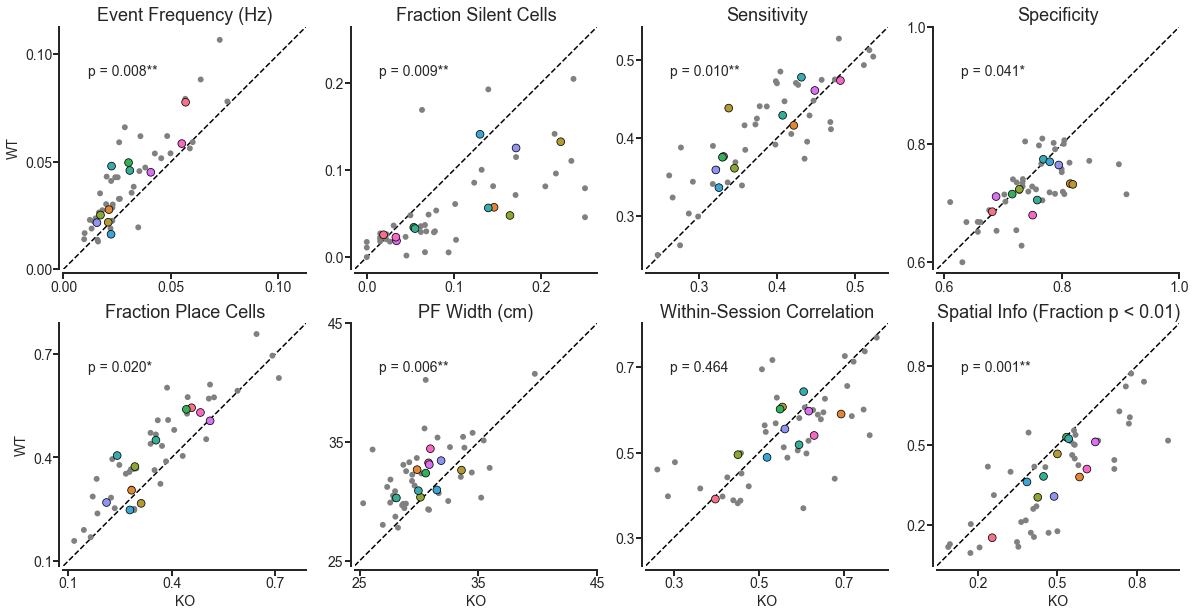

In [922]:
fig = plt.figure(figsize=(20, 10))

for i, (fname, label, tick) in enumerate(zip(fnames, labels, ticks)):
    
    with open(data_path.format(fname), 'rb') as fp:
        dfs = pkl.load(fp)

    ax = fig.add_subplot(2, 4, i + 1)

    point_plot(dfs, ax, title=fname, ticks=tick)
    
    if i < 4:
        ax.set_xlabel('')
    if i != 0 and i != 4:
        ax.set_ylabel('')
        
    ax.set_title(label, fontsize=18)
    
#     ax.set_xticks(tick)
#     ax.set_yticks(tick)

fig.savefig('./plots/comparisons.pdf')

### Examples

In [18]:
def raster(spikes, running, abspos, ax):

    for i in xrange(spikes.shape[0]):

        if running[i] and spikes[i]:

            ax.plot(abspos[i] % 1, -1 * int(abspos[i]), '|', color='k', ms=5)
    
    ax.set_ylim([-1*int(abspos[-1]), 0])
    ax.set_yticklabels([str(int(-1*x)) for x in ax.get_yticks()])
    ax.set_xticks([])
    sns.despine()
    
    ax.set_xlim([0, 1])
    ax.set_ylim([-1*int(abspos[-1]) - 0.5, 0.5])

    ax.set_aspect(1.5 / ax.get_data_ratio())
    
def heatmap(ax, *args, **kwargs):

    hm = get_heatmap(*args, **kwargs)
    sns.heatmap(np.nan_to_num(hm), ax=ax, cbar=False, vmin=0, vmax=np.nanpercentile(hm, 99.5), rasterized=True)
    ax.set_xticks([])
    
    ax.set_aspect(1.5 / ax.get_data_ratio())
    
def get_heatmap(sig, running, abs_pos, n_bins=100, fp=1,
                normalized=False):
    n_laps = int(abs_pos[-1]) + 1

    heatmap = np.zeros((n_laps, n_bins))
    counts = np.zeros((n_laps, n_bins))
    
    sig = (sig - np.nanmean(sig[~running])) / np.nanstd(sig[~running])

    for i in xrange(len(sig)):

        if not running[i]:
            continue
        if np.isnan(sig[i]):
            continue

        lap = int(abs_pos[i])
        posbin = int(np.mod(abs_pos[i] * n_bins, n_bins))

        heatmap[lap, posbin] += sig[i]
        counts[lap, posbin] += fp

    heatmap /= counts
    
    heatmap = gaussian_filter1d(heatmap, 1, axis=1)

    # Normalized
    if normalized and (np.nanmax(heatmap) > 0):
        heatmap = heatmap / np.nanmax(heatmap)

    return heatmap

In [ ]:
### Choose Examples
expt = expts[15]

red_idx = [8, 13, 23, 32]
green_idx = [59, 66, 95, 117]

In [8]:
pc_filter = ko_grp.pcs_filter()
wt_pc_filter=wt_grp.pcs_filter()

label='drawn_red'
spikes = np.nan_to_num(expt.spikes(label=label, binary=True, roi_filter=pc_filter))
sigs = expt.imagingData(dFOverF='from_file', label=label, roi_filter=pc_filter)
rois = expt.rois(label=label, roi_filter=pc_filter)

label='drawn_green'
wt_spikes = np.nan_to_num(expt.spikes(label=label, binary=True, roi_filter=wt_pc_filter))
wt_sigs = expt.imagingData(dFOverF='from_file', label=label, roi_filter=wt_pc_filter)
wt_rois = expt.rois(label=label, roi_filter=wt_pc_filter)

running_kwargs = {'min_duration': 1.0, 'min_mean_speed': 0,
                      'end_padding': 0, 'stationary_tolerance': 0.5,
                      'min_peak_speed': 5, 'direction': 'forward'}

# Alternatively simply using expt.velocity()[0] > 1 works pretty much equivalently
running = expt.runningIntervals(returnBoolList=True, **running_kwargs)[0]
abspos = ba.absolutePosition(expt.find('trial'))

In [12]:
ko_pfs = ko_grp.pfs_n(roi_filter=pc_filter)[expt]
wt_pfs = wt_grp.pfs_n(roi_filter=wt_pc_filter)[expt]

with open(data_path.format('sensitivity'), 'rb') as fp:
        sensitivity_dfs = pkl.load(fp)
        
with open(data_path.format('specificity'), 'rb') as fp:
        specificity_dfs = pkl.load(fp)
        
ko_spec = specificity_dfs[1].loc[specificity_dfs[1]['expt_id'] == expt.trial_id]
ko_sens = sensitivity_dfs[1].loc[sensitivity_dfs[1]['expt_id'] == expt.trial_id]

wt_spec = specificity_dfs[0].loc[specificity_dfs[0]['expt_id'] == expt.trial_id]
wt_sens = sensitivity_dfs[0].loc[sensitivity_dfs[0]['expt_id'] == expt.trial_id]

True
True
True
True
True
True
True
True


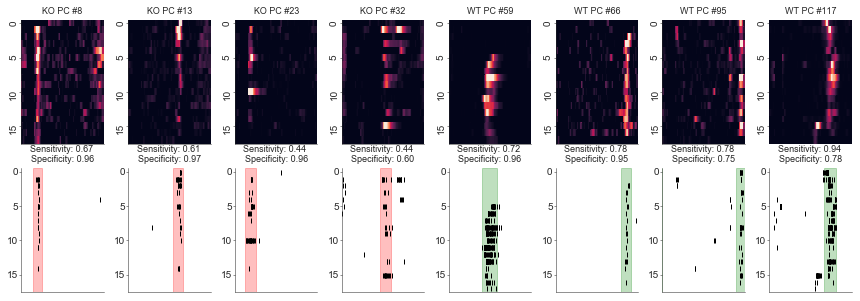

In [22]:
fig = plt.figure(figsize=(15, 5))

offset=0

n = len(red_idx) + len(green_idx)

for ii, i in enumerate(red_idx):
    
    ax = fig.add_subplot(2, n, n+ii+1)
    raster(spikes[offset + i, :], running, abspos, ax)
    ax.axvspan(ko_pfs[i][0][0], ko_pfs[i][0][1], color='r', alpha=0.25)
    
    spec = ko_spec.loc[ko_spec['roi'] == rois[i].label]['value'].values[0]
    sens = ko_sens.loc[ko_sens['roi'] == rois[i].label]['value'].values[0]
    
    ax.set_title('Sensitivity: {:.2f} \nSpecificity: {:.2f}'.format(sens, spec), fontsize=9)
    
    ax = fig.add_subplot(2, n, ii + 1)
    heatmap(ax, sigs[offset + i, :], running, abspos, normalized=True)
    ax.set_title('KO PC #{}'.format(i), fontsize=9)
    ax.set_yticks([0.5, 5.5, 10.5, 15.5])
    ax.set_yticklabels([0, 5, 10, 15])
    
for ii, i in enumerate(green_idx):
    
    ax = fig.add_subplot(2, n, int(1.5*n)+ii+1)
    raster(wt_spikes[offset + i, :], running, abspos, ax)
    
    pf_start, pf_stop = wt_pfs[i][0]
    if pf_start < pf_stop:
        ax.axvspan(pf_start, pf_stop, color='g', alpha=0.25)
    else:
        ax.axvspan(0, pf_stop, color='g', alpha=0.25)
        ax.axvspan(pf_start, 1, color='g', alpha=0.25)
    
    spec = wt_spec.loc[wt_spec['roi'] == wt_rois[i].label]['value'].values[0]
    sens = wt_sens.loc[wt_sens['roi'] == wt_rois[i].label]['value'].values[0]
    
    ax.set_title('Sensitivity: {:.2f} \nSpecificity: {:.2f}'.format(sens, spec), fontsize=9)
    
    ax = fig.add_subplot(2, n, int(0.5 * n) + ii + 1)
    heatmap(ax, wt_sigs[offset + i, :], running, abspos, normalized=True)
    ax.set_title('WT PC #{}'.format(i), fontsize=9)
    ax.set_yticks([0.5, 5.5, 10.5, 15.5])
    ax.set_yticklabels([0, 5, 10, 15])
    
fig.savefig('./plots/examples.svg')